In [ ]:

import numpy as np 
import pandas as pd 
from bs4 import BeautifulSoup
import torchvision
from torchvision import transforms, datasets, models
import torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import matplotlib.patches as patches


import torch.nn as nn
import os


In [ ]:

def generate_box(obj):
    
    xmin = int(obj.find('xmin').text)
    ymin = int(obj.find('ymin').text)
    xmax = int(obj.find('xmax').text)
    ymax = int(obj.find('ymax').text)
    
    return [xmin, ymin, xmax, ymax]

def generate_label(obj):
    if obj.find('name').text == "with_mask":
        return 2
    elif obj.find('name').text == "mask_weared_incorrect":
        return 3
    return 1

def generate_target(image_id, file): 
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, 'xml')
        objects = soup.find_all('object')

        num_objs = len(objects)

       
        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        img_id = torch.tensor([image_id])
    
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = img_id
        
        return target


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
imgs = list(sorted(os.listdir("/content/gdrive/MyDrive/images")))


In [ ]:
labels = list(sorted(os.listdir("/content/gdrive/MyDrive/annotations")))

In [ ]:
class MaskDataset(object):
    def __init__(self, transforms):
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir("/content/gdrive/MyDrive/images")))
        self.labels = list(sorted(os.listdir("/content/gdrive/MyDrive/annotations")))

    def __getitem__(self, idx):
        # load images ad masks
        file_image = 'maksssksksss'+ str(idx) + '.png'
        file_label = 'maksssksksss'+ str(idx) + '.xml'
        img_path = os.path.join("/content/gdrive/MyDrive/images/", file_image)
        label_path = os.path.join("/content/gdrive/MyDrive/annotations/", file_label)
        img = Image.open(img_path).convert("RGB")
        #Generate Label
        target = generate_target(idx, label_path)
        
        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
data_transform = transforms.Compose([
        transforms.ToTensor(), 
    ])

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

dataset = MaskDataset(data_transform)
data_loader = torch.utils.data.DataLoader(
 dataset, batch_size=4, collate_fn=collate_fn)

In [ ]:
torch.cuda.is_available()

True

# Model

In [ ]:
def get_model():
  model123 = torchvision.models.detection.retinanet_resnet50_fpn(pretrained=True)
  model = torchvision.models.detection.retinanet_resnet50_fpn(pretrained=False,num_classes = 4)
  model.backbone = model123.backbone
  model.head.classification_head.conv = model123.head.classification_head.conv
  model.head.regression_head = model123.head.regression_head
  return model

RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256)
          )
        )
        (1): Bottleneck

In [ ]:
model = get_model()

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
for imgs, annotations in data_loader:
    imgs = list(img.to(device) for img in imgs)
    annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
    print(annotations)
    break

[{'boxes': tensor([[ 79., 105., 109., 142.],
        [185., 100., 226., 144.],
        [325.,  90., 360., 141.]], device='cuda:0'), 'labels': tensor([1, 2, 1], device='cuda:0'), 'image_id': tensor([0], device='cuda:0')}, {'boxes': tensor([[321.,  34., 354.,  69.],
        [224.,  38., 261.,  73.],
        [299.,  58., 315.,  81.],
        [143.,  74., 174., 115.],
        [ 74.,  69.,  95.,  99.],
        [191.,  67., 221.,  93.],
        [ 21.,  73.,  44.,  93.],
        [369.,  70., 398.,  99.],
        [ 83.,  56., 111.,  89.]], device='cuda:0'), 'labels': tensor([2, 2, 2, 2, 2, 2, 2, 2, 1], device='cuda:0'), 'image_id': tensor([1], device='cuda:0')}, {'boxes': tensor([[ 68.,  42., 105.,  69.],
        [154.,  47., 178.,  74.],
        [238.,  34., 262.,  69.],
        [333.,  31., 366.,  65.]], device='cuda:0'), 'labels': tensor([2, 2, 2, 3], device='cuda:0'), 'image_id': tensor([2], device='cuda:0')}, {'boxes': tensor([[ 52.,  53.,  73.,  76.],
        [ 72.,  53.,  92.,  75.],
  

# Train Model

In [ ]:

num_epochs = 5
model.to(device)
    
# parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001,
                                momentum=0.9, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', factor=0.9, patience=5)

len_dataloader = len(data_loader)

for epoch in range(num_epochs):
    model.train()
    i = 0    
    epoch_loss = 0
    for imgs, annotations in data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model([imgs[0]], [annotations[0]])
        losses = sum(loss for loss in loss_dict.values())        

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        #scheduler.step(losses) 
        print(f'Iteration: {i}/{len_dataloader}, Loss: {losses}')
        epoch_loss += losses
    print(f'epoch: {epoch} losse: {epoch_loss/i}')


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Iteration: 1/214, Loss: 0.3812151253223419
Iteration: 2/214, Loss: 0.45107078552246094
Iteration: 3/214, Loss: 0.35305625200271606
Iteration: 4/214, Loss: 0.62787926197052
Iteration: 5/214, Loss: 0.5062256455421448
Iteration: 6/214, Loss: 0.27852195501327515
Iteration: 7/214, Loss: 1.250793695449829
Iteration: 8/214, Loss: 0.13452282547950745
Iteration: 9/214, Loss: 0.26380884647369385
Iteration: 10/214, Loss: 0.4024190902709961
Iteration: 11/214, Loss: 0.5203315019607544
Iteration: 12/214, Loss: 0.5334758162498474
Iteration: 13/214, Loss: 0.4330003261566162
Iteration: 14/214, Loss: 0.8391478061676025
Iteration: 15/214, Loss: 0.2304234504699707
Iteration: 16/214, Loss: 0.19522692263126373
Iteration: 17/214, Loss: 1.295072078704834
Iteration: 18/214, Loss: 0.23747524619102478
Iteration: 19/214, Loss: 0.21274057030677795
Iteration: 20/214, Loss: 0.4888359308242798
Iteration: 21/214, Loss: 0.25429558753967285
Iteration: 22/214, Loss: 0.32142043113708496
Iteration: 23/214, Loss: 0.43632030

In [ ]:
i=0

In [ ]:
for imgs, annotations in data_loader:
        i+=1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        if i == 15:
          break

In [ ]:
model.eval()
preds = model(imgs)
preds[3]

{'boxes': tensor([[172.6126,  96.8219, 189.7165, 114.7960],
         [140.4340, 103.9181, 157.0546, 120.2822],
         [230.0435,  97.7457, 246.7440, 115.1817],
         [292.1490, 107.1640, 309.5530, 124.1280],
         [ 94.3805, 132.2048, 108.9824, 146.3157],
         [184.6908, 153.3152, 218.1882, 207.2761],
         [340.0038, 136.3381, 343.3424, 142.2667],
         [275.6273, 142.6772, 284.5957, 151.8780],
         [340.3024, 134.8070, 343.2152, 139.9067],
         [339.9391, 138.4866, 343.3330, 144.7854],
         [282.6293, 106.2435, 301.7243, 125.8009],
         [140.9434, 103.3581, 157.2939, 120.1999],
         [230.5741,  96.1613, 247.1123, 114.6940],
         [ 94.2871, 130.1470, 109.1620, 146.7300],
         [292.3181, 107.5641, 308.1829, 124.4453],
         [172.8810,  97.1159, 190.1046, 114.2965],
         [230.4763,  97.4060, 246.6890, 114.6597],
         [140.8270, 104.3506, 157.1488, 120.0613],
         [140.8270, 104.3506, 157.1488, 120.0613],
         [292.7303, 10

# Function to plot image

In [ ]:
def plot_image(img_tensor, annotation, tru_annotation):
    
    fig,ax = plt.subplots(1, figsize=(8, 8))
    img = img_tensor.cpu().data

    # Display the image
    ax.imshow(img.permute(1, 2, 0))
    k = 0
    for box in annotation["boxes"]:
        xmin, ymin, xmax, ymax = box
        # Create a Rectangle patch
        clas = 'nothing'
        if int(annotation["labels"][k]) == 2:
          try:
            if annotation["scores"][k] > 0.5:
              clas = 'mask' + '; ' + str(round(float(annotation["scores"][k]),2))
              rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='g',facecolor='none')
              ax.add_patch(rect)
          except:
            clas = 'mask'
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='g',facecolor='none')
            ax.add_patch(rect)
        elif int(annotation["labels"][k]) == 3:
          try:
            if annotation["scores"][k] > 0.5:
              clas = 'inc m' + '; ' + str(round(float(annotation["scores"][k]),2))
              rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='b',facecolor='none')
              ax.add_patch(rect)
          except:
            clas = 'inc m' 
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='b',facecolor='none')
            ax.add_patch(rect)
        elif int(annotation["labels"][k]) == 1:
          try:
            if annotation["scores"][k] > 0.5:
              clas = 'no' + '; ' + str(round(float(annotation["scores"][k]),2))
              rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')
              ax.add_patch(rect)
          except:
            clas = 'no'
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')
            ax.add_patch(rect)
        if clas != 'nothing':
          plt.text(xmax, ymax, f'{clas}', size=(xmax-xmin)/4, rotation=0.,
          ha="right", va="top",
          bbox=dict(boxstyle="square",
                      ec=(1., 0.5, 0.5),
                      fc=(1., 0.8, 0.8),
                      )
            )
        k += 1


  

    plt.show()

Prediction


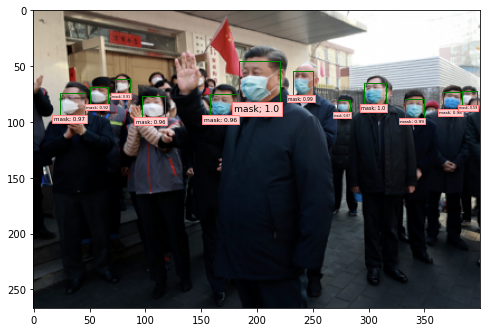

Target


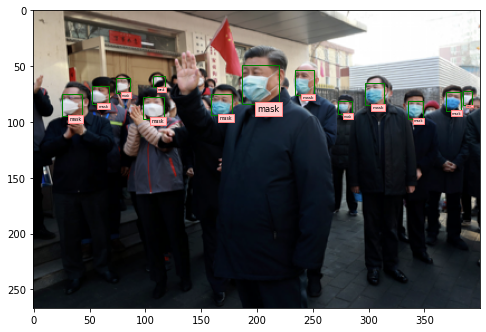

({'boxes': tensor([[ 94., 133., 109., 148.],
          [140., 105., 158., 120.],
          [174.,  98., 190., 114.],
          [230.,  99., 244., 115.],
          [294., 108., 307., 123.]], device='cuda:0'),
  'image_id': tensor([59], device='cuda:0'),
  'labels': tensor([2, 2, 2, 2, 2], device='cuda:0')},
 {'boxes': tensor([[172.6126,  96.8219, 189.7165, 114.7960],
          [140.4340, 103.9181, 157.0546, 120.2822],
          [230.0435,  97.7457, 246.7440, 115.1817],
          [292.1490, 107.1640, 309.5530, 124.1280],
          [ 94.3805, 132.2048, 108.9824, 146.3157],
          [184.6908, 153.3152, 218.1882, 207.2761],
          [340.0038, 136.3381, 343.3424, 142.2667],
          [275.6273, 142.6772, 284.5957, 151.8780],
          [340.3024, 134.8070, 343.2152, 139.9067],
          [339.9391, 138.4866, 343.3330, 144.7854],
          [282.6293, 106.2435, 301.7243, 125.8009],
          [140.9434, 103.3581, 157.2939, 120.1999],
          [230.5741,  96.1613, 247.1123, 114.6940],
       

In [ ]:
print("Prediction")
plot_image(imgs[2], preds[2], annotations[2])
print("Target")
plot_image(imgs[2], annotations[2], annotations[2])


# Save Model

In [ ]:
torch.save(model.state_dict(),'model.pt')

# Load Model

In [ ]:
model = torchvision.models.detection.retinanet_resnet50_fpn(pretrained=False,num_classes = 4)

In [ ]:
model2.load_state_dict(torch.load('model.pt'))
model2.eval()
model2.to(device)

In [ ]:
pred2 = model2(imgs)